# ADS 509 Assignment 2.1: Tokenization, Normalization, Descriptive Statistics

This notebook holds Assignment 2.1 for Module 2 in ADS 509, Applied Text Mining. Work through this notebook, writing code and answering questions where required.

In the previous assignment you put together Twitter data and lyrics data on two artists. In this assignment we explore some of the textual features of those data sets. If, for some reason, you did not complete that previous assignment, data to use for this assignment can be found in the assignment materials section of Blackboard.

This assignment asks you to write a short function to calculate some descriptive statistics on a piece of text. Then you are asked to find some interesting and unique statistics on your corpora.


## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it.

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link.

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell.

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.*


In [44]:
# Import necessary libraries
import os
import re
import emoji
import pandas as pd
import numpy as np
from collections import Counter, defaultdict
import nltk
from nltk.corpus import stopwords
from string import punctuation
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
# Download necessary NLTK resources
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

# Set stopwords
sw = stopwords.words("english")


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [22]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
# Set data location
data_location = "/content/drive/MyDrive/USD/SUMMER_2024/Modeule_2"
print(data_location)

# Set paths to the lyrics and twitter folders
twitter_folder = os.path.join(data_location, "twitter/")
lyrics_folder = os.path.join(data_location, "lyrics/")
print(twitter_folder)
print(lyrics_folder)


/content/drive/MyDrive/USD/SUMMER_2024/Modeule_2
/content/drive/MyDrive/USD/SUMMER_2024/Modeule_2/twitter/
/content/drive/MyDrive/USD/SUMMER_2024/Modeule_2/lyrics/


In [24]:
def descriptive_stats(tokens, num_tokens=5, verbose=True):
    """
    Given a list of tokens, print number of tokens, number of unique tokens,
    number of characters, lexical diversity (https://en.wikipedia.org/wiki/Lexical_diversity),
    and num_tokens most common tokens. Return a list with the number of tokens, number
    of unique tokens, lexical diversity, and number of characters.
    """
    # Calculate statistics
    num_tokens = len(tokens)
    num_unique_tokens = len(set(tokens))
    lexical_diversity = len(set(tokens)) / len(tokens)
    num_characters = sum(len(token) for token in tokens)

    if verbose:
        print(f"There are {num_tokens} tokens in the data.")
        print(f"There are {num_unique_tokens} unique tokens in the data.")
        print(f"There are {num_characters} characters in the data.")
        print(f"The lexical diversity is {lexical_diversity:.3f} in the data.")

    return [num_tokens, num_unique_tokens, lexical_diversity, num_characters]


In [25]:
# Sample text for testing
text = "here is some example text with other example text here in this text".split()

# Test the descriptive_stats function
assert(descriptive_stats(text, verbose=True)[0] == 13)
assert(descriptive_stats(text, verbose=False)[1] == 9)
assert(abs(descriptive_stats(text, verbose=False)[2] - 0.69) < 0.02)
assert(descriptive_stats(text, verbose=False)[3] == 55)


There are 13 tokens in the data.
There are 9 unique tokens in the data.
There are 55 characters in the data.
The lexical diversity is 0.692 in the data.


Q: Why is it beneficial to use assertion statements in your code?

A: Assertion statements offer a valuable method for testing and debugging code, providing benefits such as facilitating error handling. Essentially, these statements evaluate whether a given condition or statement is true, and if not, they trigger an Assertion Error.



## Data Input

Now read in each of the corpora. For the lyrics data, it may be convenient to store the entire contents of the file to make it easier to inspect the titles individually, as you'll do in the last part of the assignment. In the solution, I stored the lyrics data in a dictionary with two dimensions of keys: artist and song. The value was the file contents. A data frame would work equally well.

For the Twitter data, we only need the description field for this assignment. Feel free all the descriptions read it into a data structure. In the solution, I stored the descriptions as a dictionary of lists, with the key being the artist.




### Read in the Lyrics Data

In [27]:
# Initialize an empty DataFrame for the lyrics data
lyrics_data = pd.DataFrame(columns=['artist', 'song', 'lyrics'])

# Read the lyrics data from the directory
for artist in os.listdir(lyrics_folder):
    artist_folder = os.path.join(lyrics_folder, artist)
    if not os.path.isdir(artist_folder):  # Skip if not a directory
        continue
    for song in os.listdir(artist_folder):
        song_file = os.path.join(artist_folder, song)
        with open(song_file, 'r', encoding='utf-8') as file:
            lyrics = file.read()
            new_row = pd.DataFrame({'artist': [artist], 'song': [song], 'lyrics': [lyrics]})
            lyrics_data = pd.concat([lyrics_data, new_row], ignore_index=True)

# Display the first few rows of the lyrics data
lyrics_data.head()


,artist,song,lyrics
0,cher,cher_comeandstaywithme.txt,"""Come And Stay With Me""\n\n\n\nI'll send away ..."
1,cher,cher_mastersofwar.txt,"""Masters Of War""\n\n\n\nCome you masters of wa..."
2,cher,cher_oneofus.txt,"""One Of Us""\n\n\n\nThey passed me by, all of t..."
3,cher,cher_walkinginmemphis.txt,"""Walking In Memphis""\n\n\n\nPut on my blue sue..."
4,cher,cher_tonightillbestayingherewithyou.txt,"""Tonight I'll Be Staying Here With You""\n\n\n\..."


### Read the Twitter Data

In [28]:
# Initialize an empty list to store DataFrames for Twitter descriptions
twitter_dfs = []

# Read the Twitter descriptions from the directory
for file in os.listdir(twitter_folder):
    if file == ".DS_Store":
        continue
    if file.endswith("_data.txt"):  # Check for "_data.txt" specifically
        file_path = os.path.join(twitter_folder, file)
        with open(file_path, 'r', encoding='utf-8') as file_obj:
            content = file_obj.read()
            lines = content.splitlines()
            column_names = lines[0].split('\t')
            data = [line.split('\t') for line in lines[1:]]
            twitter_df = pd.DataFrame(data, columns=column_names)
            twitter_dfs.append(twitter_df)

# Concatenate all Twitter description DataFrames
twitter_df = pd.concat(twitter_dfs, ignore_index=True)

# Display the first few rows of the Twitter data
twitter_df.head()


,screen_name,name,id,location,followers_count,friends_count,description
0,AngelxoArts,Angelxo,1424055675030806529,"Zacatlan, Puebla, Mexico",29,535,"""I love chill"" •Facebook / Instagram / SoundCl..."
1,songsfornikola,johnny,1502717352575651840,,6,318,"books, movies, music, nature & TV shows. OG Sw..."
2,thibaud_lola,Thibaud Lola,1502407708246478852,,3,69,(Am)auteur en herbe 🌱 - juriste en paille 🤡 - ...
3,KyleSew2112,Kyle S 🌹🇬🇧🇺🇦,3423966821,South East London,1258,3444,This Twitter profile is full of sarcasm and ra...
4,MusiFlo,MusiFlo,3324069364,Canada,470,1706,Flora Youssef - Blogger & Founder Posting revi...


### Read in the Twitter Follower IDs

In [29]:
# Initialize an empty list to store DataFrames for follower IDs
follower_ids_dfs = []

# Read the follower IDs from the directory
for file in os.listdir(twitter_folder):
    if file == ".DS_Store":
        continue
    if file.endswith("followers.txt"):  # Check for "followers.txt" specifically
        file_path = os.path.join(twitter_folder, file)
        artist_name = file.split('_')[0]  # Extract the artist name from the file name
        with open(file_path, 'r', encoding='utf-8') as file_obj:
            content = file_obj.read()
            lines = content.splitlines()
            follower_ids = [line.split('\t')[0] for line in lines[1:]]  # Extract the first column (follower IDs)
            follower_ids_df = pd.DataFrame(follower_ids, columns=['id'])
            follower_ids_df['artist_name'] = artist_name  # Add the artist name as a new column
            follower_ids_dfs.append(follower_ids_df)

# Concatenate all follower IDs DataFrames
follower_ids_concat = pd.concat(follower_ids_dfs, ignore_index=True)

# Display the last few rows of the follower IDs data
follower_ids_concat.tail()


,id,artist_name
4353691,385464947,cher
4353692,554334793,cher
4353693,150980088,cher
4353694,308168108,cher
4353695,338867174,cher


### Merge Twitter Descriptions with Follower IDs

In [30]:
# Merge Twitter descriptions with follower IDs on 'id'
joined_twitter_data = pd.merge(twitter_df, follower_ids_concat, on='id', how='inner')

# Display the first few rows of the merged Twitter data
joined_twitter_data.head()


,screen_name,name,id,location,followers_count,friends_count,description,artist_name
0,AngelxoArts,Angelxo,1424055675030806529,"Zacatlan, Puebla, Mexico",29,535,"""I love chill"" •Facebook / Instagram / SoundCl...",robynkonichiwa
1,songsfornikola,johnny,1502717352575651840,,6,318,"books, movies, music, nature & TV shows. OG Sw...",robynkonichiwa
2,songsfornikola,johnny,1502717352575651840,,6,318,"books, movies, music, nature & TV shows. OG Sw...",cher
3,songsfornikola,johnny,1502717352575651840,,6,318,"books, movies, music, nature & TV shows. OG Sw...",robynkonichiwa
4,songsfornikola,johnny,1502717352575651840,,6,318,"books, movies, music, nature & TV shows. OG Sw...",cher


## Data Cleaning

Now clean and tokenize your data. Remove punctuation chacters (available in the `punctuation` object in the `string` library), split on whitespace, fold to lowercase, and remove stopwords. Store your cleaned data, which must be accessible as an interable for `descriptive_stats`, in new objects or in new columns in your data frame.



In [33]:
# Define the Cleaning and Tokenization Function
# Define stopwords list
stopwords_list = stopwords.words('english')

# Define the cleaning and tokenization function
def clean_tokenize(text):
    # Remove punctuation
    text_no_punct = ''.join(char for char in text if char not in punctuation)
    # Split on whitespace
    tokens = word_tokenize(text_no_punct)
    # Fold to lowercase
    tokens_lower = [token.lower() for token in tokens]
    # Remove stopwords
    tokens_no_stopwords = [token for token in tokens_lower if token not in stopwords_list]
    return tokens_no_stopwords

In [34]:
# Clean and Tokenize Twitter Descriptions
# Create your clean twitter data here
joined_twitter_data['cleaned_description'] = joined_twitter_data['description'].apply(clean_tokenize)

# Check to see if the tokenization and cleaning went properly
joined_twitter_data.head()

,screen_name,name,id,location,followers_count,friends_count,description,artist_name,cleaned_description
0,AngelxoArts,Angelxo,1424055675030806529,"Zacatlan, Puebla, Mexico",29,535,"""I love chill"" •Facebook / Instagram / SoundCl...",robynkonichiwa,"[love, chill, •facebook, instagram, soundcloud..."
1,songsfornikola,johnny,1502717352575651840,,6,318,"books, movies, music, nature & TV shows. OG Sw...",robynkonichiwa,"[books, movies, music, nature, tv, shows, og, ..."
2,songsfornikola,johnny,1502717352575651840,,6,318,"books, movies, music, nature & TV shows. OG Sw...",cher,"[books, movies, music, nature, tv, shows, og, ..."
3,songsfornikola,johnny,1502717352575651840,,6,318,"books, movies, music, nature & TV shows. OG Sw...",robynkonichiwa,"[books, movies, music, nature, tv, shows, og, ..."
4,songsfornikola,johnny,1502717352575651840,,6,318,"books, movies, music, nature & TV shows. OG Sw...",cher,"[books, movies, music, nature, tv, shows, og, ..."


In [35]:
# Clean and Tokenize Lyrics Data
# Create your clean lyrics data here
lyrics_data['lyrics_clean'] = lyrics_data['lyrics'].apply(clean_tokenize)

# Display the first few rows of the cleaned lyrics data
lyrics_data.head()


,artist,song,lyrics,lyrics_clean
0,cher,cher_comeandstaywithme.txt,"""Come And Stay With Me""\n\n\n\nI'll send away ...","[come, stay, ill, send, away, false, pride, il..."
1,cher,cher_mastersofwar.txt,"""Masters Of War""\n\n\n\nCome you masters of wa...","[masters, war, come, masters, war, build, guns..."
2,cher,cher_oneofus.txt,"""One Of Us""\n\n\n\nThey passed me by, all of t...","[one, us, passed, great, romances, felt, robbi..."
3,cher,cher_walkinginmemphis.txt,"""Walking In Memphis""\n\n\n\nPut on my blue sue...","[walking, memphis, put, blue, suede, shoes, bo..."
4,cher,cher_tonightillbestayingherewithyou.txt,"""Tonight I'll Be Staying Here With You""\n\n\n\...","[tonight, ill, staying, throw, ticket, window,..."


## Basic Descriptive Statistics

Call your `descriptive_stats` function on both your lyrics data and your twitter data and for both artists (four total calls).

In [36]:
# Call to descriptive_stats for lyrics data
for text in lyrics_data['lyrics_clean']:
    try:
        tokens = text  # Add this line to get the tokens from the text
        stats_verbose_true = descriptive_stats(text, verbose=True)
        stats_verbose_false = descriptive_stats(text, verbose=False)
        expected_num_tokens = len(tokens)
        expected_num_unique_tokens = len(set(tokens))
        expected_lexical_diversity = len(set(tokens)) / len(tokens)
        expected_num_characters = sum(len(token) for token in tokens)

        assert(stats_verbose_true[0] == expected_num_tokens)
        assert(stats_verbose_false[1] == expected_num_unique_tokens)
        assert(abs(stats_verbose_false[2] - expected_lexical_diversity) < 0.02)
        assert(stats_verbose_false[3] == expected_num_characters)
    except AssertionError:
        print(f"Assertion failed for text: {text}")
    except Exception as e:
        print(f"Error processing text: {text}. Error: {e}")


There are 80 tokens in the data.
There are 48 unique tokens in the data.
There are 342 characters in the data.
The lexical diversity is 0.600 in the data.
There are 170 tokens in the data.
There are 124 unique tokens in the data.
There are 803 characters in the data.
The lexical diversity is 0.729 in the data.
There are 117 tokens in the data.
There are 54 unique tokens in the data.
There are 595 characters in the data.
The lexical diversity is 0.462 in the data.
There are 175 tokens in the data.
There are 85 unique tokens in the data.
There are 917 characters in the data.
The lexical diversity is 0.486 in the data.
There are 73 tokens in the data.
There are 46 unique tokens in the data.
There are 389 characters in the data.
The lexical diversity is 0.630 in the data.
There are 114 tokens in the data.
There are 64 unique tokens in the data.
There are 514 characters in the data.
The lexical diversity is 0.561 in the data.
There are 145 tokens in the data.
There are 86 unique tokens in t

In [37]:
# Set a counter to only print out 100 values to prevent crashes
counter = 0
for text in joined_twitter_data['cleaned_description']:
    try:
        tokens = text  # Add this line to get the tokens from the text
        stats_verbose_true = descriptive_stats(text, verbose=True)
        stats_verbose_false = descriptive_stats(text, verbose=False)
        expected_num_tokens = len(tokens)
        expected_num_unique_tokens = len(set(tokens))
        expected_lexical_diversity = len(set(tokens)) / len(tokens)
        expected_num_characters = sum(len(token) for token in tokens)

        assert(stats_verbose_true[0] == expected_num_tokens)
        assert(stats_verbose_false[1] == expected_num_unique_tokens)
        assert(abs(stats_verbose_false[2] - expected_lexical_diversity) < 0.02)
        assert(stats_verbose_false[3] == expected_num_characters)
    except AssertionError:
        print(f"Assertion failed for text: {text}")
    except Exception as e:
        print(f"Error processing text: {text}. Error: {e}")

    counter += 1
    if counter >= 100:
        break


There are 7 tokens in the data.
There are 7 unique tokens in the data.
There are 68 characters in the data.
The lexical diversity is 1.000 in the data.
There are 16 tokens in the data.
There are 16 unique tokens in the data.
There are 87 characters in the data.
The lexical diversity is 1.000 in the data.
There are 16 tokens in the data.
There are 16 unique tokens in the data.
There are 87 characters in the data.
The lexical diversity is 1.000 in the data.
There are 16 tokens in the data.
There are 16 unique tokens in the data.
There are 87 characters in the data.
The lexical diversity is 1.000 in the data.
There are 16 tokens in the data.
There are 16 unique tokens in the data.
There are 87 characters in the data.
The lexical diversity is 1.000 in the data.
There are 24 tokens in the data.
There are 22 unique tokens in the data.
There are 99 characters in the data.
The lexical diversity is 0.917 in the data.
There are 18 tokens in the data.
There are 17 unique tokens in the data.
There

Q: How do you think the "top 5 words" would be different if we left stopwords in the data?

A: Leaving stop words in the text can result in many filler words, potentially skewing the top 5 words identified. In analyzing a sentence or paragraph, insignificant words like "a," "but," "the," and "is" serve as mere linguistic fillers and do not contribute substantially to understanding the main topic. Instead, the focus is on extracting essential words that are crucial for comprehending the paragraph's subject matter. For instance, words like "about," "money," "bitcoin," "positive," "negative," and "crash" carry greater significance and aid in grasping the essence of the content.

---

Q: What were your prior beliefs about the lexical diversity between the artists? Does the difference (or lack thereof) in lexical diversity between the artists conform to your prior beliefs?

A: My initial understanding of lexical diversity was based on the number of unique words in a text, particularly in song lyrics. Although the analysis output includes artist names, it is noticeable that Robyn dominates the top half, while Cher features predominantly in the bottom portion (based on the data frame order provided). I find it intriguing that certain songs by both artists show more lexical diversity than others. This phenomenon is logical in music because many popular songs rely on repetitive phrases over catchy beats, leading to fewer unique words. Conversely, songs focused on storytelling or vivid descriptions tend to have more diverse vocabulary. A song's lexical diversity closer to 0 suggests fewer unique words, while values above say, 0.5 indicate richer lyrical diversity.



## Specialty Statistics

The descriptive statistics we have calculated are quite generic. You will now calculate a handful of statistics tailored to these data.

1. Ten most common emojis by artist in the twitter descriptions.
1. Ten most common hashtags by artist in the twitter descriptions.
1. Five most common words in song titles by artist.
1. For each artist, a histogram of song lengths (in terms of number of tokens)

We can use the `emoji` library to help us identify emojis and you have been given a function to help you.


In [38]:
assert(emoji.is_emoji("❤️"))
assert(not emoji.is_emoji(":-)"))

### Emojis 😁

What are the ten most common emojis by artist in the twitter descriptions?


In [39]:
# Function to extract emojis from text
def extract_emojis(text):
    return [char for char in text if emoji.is_emoji(char)]

# Initialize a dictionary to store emoji counts by artist
emoji_counts = defaultdict(Counter)

# Iterate over the Twitter data to count emojis by artist
for index, row in joined_twitter_data.iterrows():
    artist = row['artist_name']
    description = row['description']
    emojis = extract_emojis(description)
    emoji_counts[artist].update(emojis)

# Display the ten most common emojis by artist
for artist, counts in emoji_counts.items():
    print(f"Artist: {artist}")
    print(counts.most_common(10))
    print()


Artist: robynkonichiwa
[('🌈', 7007), ('❤', 5949), ('🏳', 5315), ('♥', 3668), ('✨', 3044), ('🏻', 2036), ('🏼', 1592), ('✌', 1571), ('💙', 1096), ('♀', 1090)]

Artist: cher
[('❤', 80393), ('🌈', 49868), ('🏳', 35196), ('♥', 34543), ('✨', 30285), ('💙', 21666), ('🏻', 21470), ('🌊', 20334), ('✌', 17155), ('💜', 16829)]



### Hashtags

What are the ten most common hashtags by artist in the twitter descriptions?


In [40]:
# Function to extract hashtags from text
def extract_hashtags(text):
    return [word for word in text.split() if word.startswith('#')]

# Initialize a dictionary to store hashtag counts by artist
hashtag_counts = defaultdict(Counter)

# Iterate over the Twitter data to count hashtags by artist
for index, row in joined_twitter_data.iterrows():
    artist = row['artist_name']
    description = row['description']
    hashtags = extract_hashtags(description)
    hashtag_counts[artist].update(hashtags)

# Display the ten most common hashtags by artist
for artist, counts in hashtag_counts.items():
    print(f"Artist: {artist}")
    print(counts.most_common(10))
    print()


Artist: robynkonichiwa
[('#BlackLivesMatter', 484), ('#BLM', 404), ('#blacklivesmatter', 302), ('#1', 247), ('#music', 181), ('#', 169), ('#Music', 123), ('#EDM', 90), ('#LGBTQ', 76), ('#blm', 71)]

Artist: cher
[('#BLM', 8050), ('#Resist', 5034), ('#BlackLivesMatter', 4398), ('#resist', 3150), ('#FBR', 2771), ('#blacklivesmatter', 2566), ('#TheResistance', 2470), ('#1', 2286), ('#', 1984), ('#Resistance', 1524)]



### Song Titles

What are the five most common words in song titles by artist? The song titles should be on the first line of the lyrics pages, so if you have kept the raw file contents around, you will not need to re-read the data.


In [41]:
# Function to extract words from song titles
def extract_words(text):
    # Remove punctuation and split on whitespace
    text_no_punct = ''.join(char for char in text if char not in punctuation)
    words = text_no_punct.lower().split()
    # Remove stopwords
    words_no_stopwords = [word for word in words if word not in stopwords_list]
    return words_no_stopwords

# Initialize a dictionary to store word counts by artist
title_word_counts = defaultdict(Counter)

# Iterate over the lyrics data to count words in song titles by artist
for index, row in lyrics_data.iterrows():
    artist = row['artist']
    song_title = row['song']
    words = extract_words(song_title)
    title_word_counts[artist].update(words)

# Display the five most common words in song titles by artist
for artist, counts in title_word_counts.items():
    print(f"Artist: {artist}")
    print(counts.most_common(5))
    print()


Artist: cher
[('chercomeandstaywithmetxt', 1), ('chermastersofwartxt', 1), ('cheroneofustxt', 1), ('cherwalkinginmemphistxt', 1), ('chertonightillbestayingherewithyoutxt', 1)]

Artist: robyn
[('robynmissingutxt', 1), ('robynhoneytxt', 1), ('robynrobotboytxt', 1), ('robynherewegotxt', 1), ('robynkonichiwabitchestxt', 1)]



### Song Lengths

For each artist, a histogram of song lengths (in terms of number of tokens). If you put the song lengths in a data frame with an artist column, matplotlib will make the plotting quite easy. An example is given to help you out.


In [42]:
# Calculate the number of tokens per song
lyrics_data['num_tokens'] = lyrics_data['lyrics_clean'].apply(len)

# Initialize a dictionary to store song lengths by artist
song_lengths_by_artist = defaultdict(list)

# Iterate over the lyrics data to get song lengths by artist
for index, row in lyrics_data.iterrows():
    artist = row['artist']
    num_tokens = row['num_tokens']
    song_lengths_by_artist[artist].append(num_tokens)


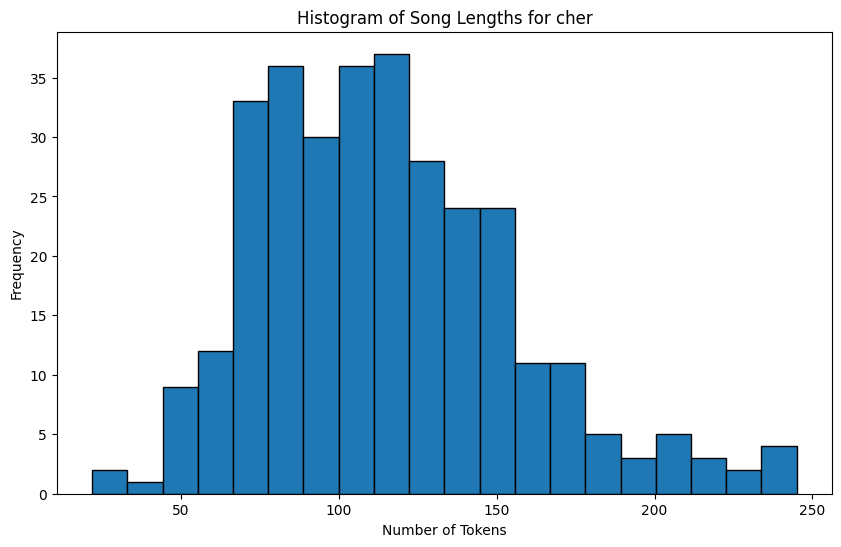

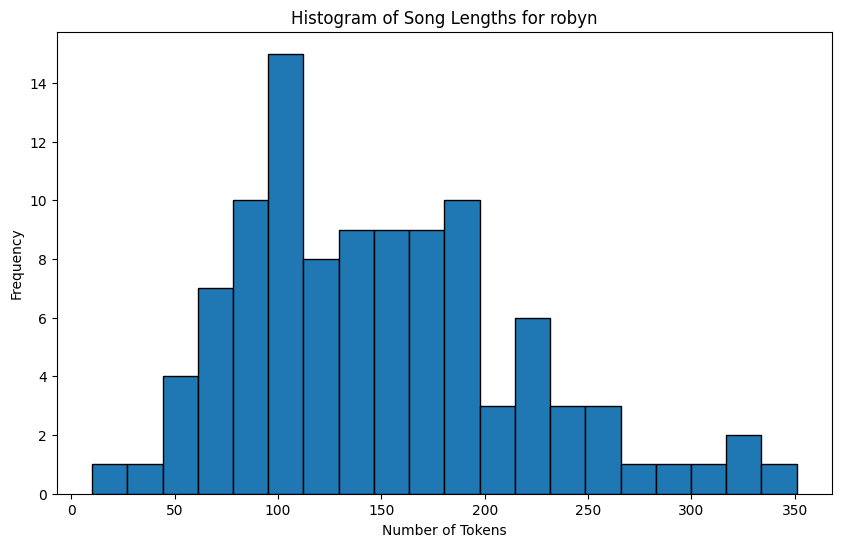

In [45]:
# Create histograms of song lengths by artist
for artist, lengths in song_lengths_by_artist.items():
    plt.figure(figsize=(10, 6))
    plt.hist(lengths, bins=20, edgecolor='black')
    plt.title(f'Histogram of Song Lengths for {artist}')
    plt.xlabel('Number of Tokens')
    plt.ylabel('Frequency')
    plt.show()

Since the lyrics may be stored with carriage returns or tabs, it may be useful to have a function that can collapse whitespace, using regular expressions, and be used for splitting.

Q: What does the regular expression `'\s+'` match on?

A: The regular expression \s+ matches sequences of one or more whitespace characters. Whitespace characters include spaces, tabs, carriage returns, and newline characters. For example, in the string "Hello World\tThis is\nan example," \s+ would match the multiple spaces between "Hello" and "World," the tab character between "World" and "This," and the newline character between "This" and "an." This regex helps collapse multiple whitespace characters into a single space to normalize text data.


In [49]:
collapse_whitespace = re.compile(r'\s+')

def tokenize_lyrics(lyric) :
    """strip and split on whitespace"""
    return([item.lower() for item in collapse_whitespace.split(lyric)])

In [50]:
# Apply the function to tokenize lyrics
lyrics_data['tokenized_lyrics'] = lyrics_data['lyrics'].apply(tokenize_lyrics)

# Display the first few rows to check the tokenized lyrics
lyrics_data[['artist', 'song', 'tokenized_lyrics']].head()


,artist,song,tokenized_lyrics
0,cher,cher_comeandstaywithme.txt,"[""come, and, stay, with, me"", i'll, send, away..."
1,cher,cher_mastersofwar.txt,"[""masters, of, war"", come, you, masters, of, w..."
2,cher,cher_oneofus.txt,"[""one, of, us"", they, passed, me, by,, all, of..."
3,cher,cher_walkinginmemphis.txt,"[""walking, in, memphis"", put, on, my, blue, su..."
4,cher,cher_tonightillbestayingherewithyou.txt,"[""tonight, i'll, be, staying, here, with, you""..."


In [51]:
# Calculate song lengths with tokenized lyrics
song_lengths_2 = lyrics_data.groupby('artist')['tokenized_lyrics'].apply(lambda x: x.str.len()).reset_index()


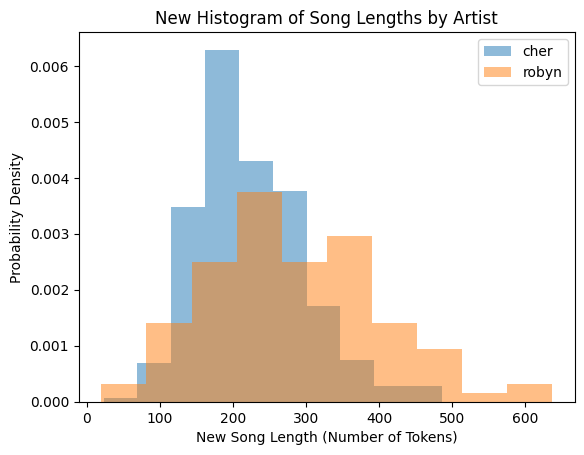

In [52]:
# Your lyric length comparison chart here.
# Plot the histogram of new song lengths by artist
song_lengths_2.groupby('artist')['tokenized_lyrics'].plot(kind="hist", density=True, alpha=0.5, legend=True)

# Add labels and title to the plot
plt.xlabel('New Song Length (Number of Tokens)')
plt.ylabel('Probability Density')
plt.title('New Histogram of Song Lengths by Artist')

# Show the plot
plt.show()
